# Randomized Cross-Validation

In [1]:
import os
os.chdir("../../")
# Import packages
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.decomposition as mat_decomp
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, add_dummy_feature

import os, sys
import time
from tqdm import tqdm
from pathlib import Path as P
import itertools
import pickle
from datetime import datetime

from scripts.metrics import (
    macro_averaged_mean_absolute_error,
    macro_averaged_mean_squared_error
)


In [20]:
def random_seed(seed_value):
    """Ensure reproducible results"""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value) 
    random.seed(seed_value)
random_seed(1)

In [2]:
def neg_log_loss(theta, output, y, class_w):
    """Implements negative log likelihood for ordinal regression."""
    theta_km1 = torch.roll(theta, 1) #\theta_{k-1}
    theta_km1[0] = -99999
    t1 = theta_km1[y]
    
    t0 = theta[y]
    
    eps = 1e-10 # Deal with potential issues in the log.
           
    l = torch.sigmoid(t0-output)-torch.sigmoid(t1-output)      
    l = torch.clamp(l, eps, 1-eps)
    nll = - torch.log(l)
    nll *= class_w[y]
    return torch.mean(nll)

class ordinalRegression(nn.Module):
    """Implements 2 layer fully connected neural network """
    def __init__(self, n_features, start, end, n_classes, nodes):
        super(ordinalRegression, self).__init__()
                
        self.l1 = nn.Linear(n_features, nodes) 
        self.l2 = nn.Linear(nodes, int(nodes/2))
        self.output = nn.Linear(int(nodes/2), 1)
        
        self.theta = nn.Parameter(
            torch.linspace(start=start, end=end,
                           steps=n_classes, dtype=torch.float)
            )        
        
        self.activation = nn.LeakyReLU()
        
        
    def forward(self, x):
        x = self.l1(x)
        x = self.activation(x)
        x = self.l2(x)        
        x = self.activation(x)
        return self.output(x), self.theta

def train(df, valid_split, n_classes, nodes, class_weights, 
          epochs, batch_size=32, lr=0.01, start=-1,
          end=5, pca=True, dates=True,verbose=True,
          valid=False, seed=1):
    """Implements training loop"""
    
    random_seed(seed)
    
    _, y ,X_train, X_valid, y_train, y_valid = prep_data(df, test_split=valid_split, pca=pca, dates=dates)
    
    # Convert X, y into Tensor. 
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).long()
    class_weights = torch.from_numpy(class_weights).float()
    
    # Training variables
    model = ordinalRegression(X_train.shape[1], start, end, n_classes, nodes)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_is = []
    loss_valid = []
    
    for ep in range(epochs):
        for i in (tqdm(range(0,len(X_train), batch_size)) if verbose else range(0,len(X_train), batch_size)):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            output, theta = model(X_batch)
            loss = neg_log_loss(theta, output, y_batch, class_weights)

            loss.backward() # Compute gradients 

            optimizer.step() # Update w, theta
            optimizer.zero_grad()

            with torch.no_grad(): # Projected Gradient Descent, enforce constraint \theta_1 < \theta_2 < \theta_k
                for i in range(len(theta)-1):
                    theta[i].clamp_(-1.0e6, theta[i+1].data)
            
        # After the epoch, compute the validation loss
        if valid:

            X_valid_torch = torch.from_numpy(X_valid).float()
            y_valid_torch = torch.from_numpy(y_valid).long()
            
            with torch.no_grad():
                ystar_is, thresh_is = model(X_train) #training
                ystar_oos, thresh_oos = model(X_valid_torch) #validation
                
                is_loss = neg_log_loss(thresh_is, ystar_is, y_train, class_weights)
                valid_loss = neg_log_loss(thresh_oos, ystar_oos, y_valid_torch, class_weights)
                 
                loss_is.append(is_loss)
                loss_valid.append(valid_loss)
                
    return loss_is, model, theta.detach(), loss_valid, X_valid, y_valid

In [3]:
def make_predictions(X, model, theta):
    """Make predictions from the model."""
    X_torch = torch.from_numpy(X).float()
    with torch.no_grad():
        latent,_ = model(X_torch)
    preds = torch.sum(latent>theta,dim=1)
    preds = torch.where(preds>=len(theta), len(theta)-1, preds)
    return preds, latent

def remove_dates(X):
    """Drop date feature engineering"""
    todrop = ['Is_month_end_True','Is_month_start_True',
              'Is_quarter_end_True', 'Is_quarter_start_True',
              'Is_year_end_True', 'Is_year_start_True']
    
    XX = X.drop(columns=todrop)
    return XX


def prep_data(df, test_split="2014-12-31", pca=True, dates=True):
    """Prepares the data"""
    #print(f"Full data range : [{df['date'].min(), df['date'].max()}]")
    X = df.drop(columns=["dangerLevel", "date"])  
    y = df["dangerLevel"]
    y -= 1 # So we can index by y.
    
    # Dummies
    cat_cols = [
        "station",
        "Is_month_end",
        "Is_month_start",
        "Is_quarter_end",
        "Is_quarter_start",
        "Is_year_end",
        "Is_year_start"
    ]
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    
    if not dates:
        #print("Drop dates")
        X = remove_dates(X)

    # Split train & test
    # mask = (df.index > '2000-01-01') & (df.index < '2015-01-01')
    mask = df.date < test_split
    X_train = X[mask].values
    y_train = y[mask].values
    X_test = X[~mask].values
    y_test = y[~mask].values

    # Scale data without bias & add dummy variable
    scaler = StandardScaler()
    encoder = LabelEncoder()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    

    if pca:
        #print("Do PCA")
        pca = mat_decomp.PCA(0.95).fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)


    return X, y, X_train, X_test, y_train, y_test

In [21]:
def do_cv(df, split, n_classes, parameters):
    """Perform cross validation"""
    score = []
    for comb in parameters:
        print(comb)
        
        # Fit model and make predictions.
        losses, model, theta, _, X_test, y_test = train(df, split, n_classes, **comb, verbose = False)
        y_pred_oos, _ = make_predictions(X_test, model, theta)
        
        # Compute metrics
        bac_oos = metrics.balanced_accuracy_score(y_test, y_pred_oos.numpy())
        mamae = macro_averaged_mean_absolute_error(y_test, y_pred_oos.numpy())
        mamse = macro_averaged_mean_squared_error(y_test, y_pred_oos.numpy())
        wf1 = metrics.f1_score(y_test, y_pred_oos.numpy(), average="weighted")

        print(f"\t\tBalanced Accuracy : {bac_oos:.4f}")
        print(f"\t\tMacro Averaged MAE : {mamae:.4f}")
        print(f"\t\tMacro Averaged MSE : {mamse:.4f}")
        print(f"\t\tWeighted F1 : {wf1:.4f}")
        
        # Save

        score.append({"bac":bac_oos,"mamae":mamae,"mamse":mamse,"wf1":wf1})    

    cv_results = pd.DataFrame(score)
    return parameters[cv_results.idxmin()["mamse"]], cv_results

## Perform Cross-validation

In [5]:
df = pd.read_csv("./data/clean/fulldataset.csv")

mask = df.date < "2015-01-01"
training = df[mask]

# Validation sets.

y = df["dangerLevel"].values.astype("int16") - 1 
n_classes = len(np.unique(y))
class_weights = len(y) / (n_classes * np.bincount(y))

In [18]:
# Define parameters.

parameters = {
    "nodes":[5,20,100,200],
    "class_weights":[class_weights, np.array([1,1,1,1])],
    "epochs":[10,15,20],
    "batch_size":[2, 8, 32],
    "lr":[0.001, 0.01, 0.1],
    "start":[-5, -10],
    "end":[5, 10],    
    "pca":[True, False],
    "dates":[True, False]
}

keys, values = zip(*parameters.items())
experiments = [dict(zip(keys,v)) for v in itertools.product(*values)]
experiments = random.sample(experiments, 100)

In [6]:
##### This does not need to be executed as the results are saved. #####

opt_params, res_table = do_cv(training, "2010-01-01", n_classes, experiments)

print("Best parameters",opt_params)

# Save results to file.
fname = f"./cross_validation/ordloss/opt_par_cv.p"
pickle.dump(opt_params, open(fname, "wb"))
pickle.dump(res_table, open("./cross_validation/ordloss/restable_valid.p","wb"))

{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 15, 'batch_size': 2, 'lr': 0.1, 'start': -5, 'end': 10, 'pca': False, 'dates': False}
Drop dates


/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.1738
		Macro Averaged MAE : 1.6500
		Macro Averaged MSE : 4.1000
		Weighted F1 : 0.0720
{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 20, 'batch_size': 2, 'lr': 0.001, 'start': -10, 'end': 10, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.6446
		Macro Averaged MAE : 0.3607
		Macro Averaged MSE : 0.3715
		Weighted F1 : 0.7468
{'nodes': 20, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 10, 'batch_size': 32, 'lr': 0.001, 'start': -5, 'end': 10, 'pca': False, 'dates': False}
Drop dates
		Balanced Accuracy : 0.6127
		Macro Averaged MAE : 0.3991
		Macro Averaged MSE : 0.4228
		Weighted F1 : 0.6204
{'nodes': 20, 'class_weights': array([1, 1, 1, 1]), 'epochs': 10, 'batch_size': 32, 'lr': 0.001, 'start': -5, 'end': 5, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.3668
		Macro Averaged MAE : 0.6355
		Macro Averaged MSE : 0.6403
		Weighted F1 : 0.5594
{'nodes': 

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.7198
		Macro Averaged MAE : 0.2877
		Macro Averaged MSE : 0.3026
		Weighted F1 : 0.7701
{'nodes': 5, 'class_weights': array([1, 1, 1, 1]), 'epochs': 20, 'batch_size': 32, 'lr': 0.01, 'start': -5, 'end': 10, 'pca': True, 'dates': True}
Do PCA
		Balanced Accuracy : 0.3872
		Macro Averaged MAE : 0.6189
		Macro Averaged MSE : 0.6310
		Weighted F1 : 0.5921
{'nodes': 200, 'class_weights': array([1, 1, 1, 1]), 'epochs': 15, 'batch_size': 8, 'lr': 0.001, 'start': -10, 'end': 5, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.5411
		Macro Averaged MAE : 0.4673
		Macro Averaged MSE : 0.4840
		Weighted F1 : 0.7280
{'nodes': 100, 'class_weights': array([1, 1, 1, 1]), 'epochs': 20, 'batch_size': 32, 'lr': 0.1, 'start': -5, 'end': 10, 'pca': True, 'dates': True}
Do PCA
		Balanced Accuracy : 0.2492
		Macro Averaged MAE : 1.5025
		Macro Averaged MSE : 3.5075
		Weighted F1 : 0.0645
{'nodes': 100, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.0712
		Macro Averaged MAE : 2.4523
		Macro Averaged MSE : 7.3091
		Weighted F1 : 0.0292
{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 10, 'batch_size': 8, 'lr': 0.001, 'start': -5, 'end': 5, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.7585
		Macro Averaged MAE : 0.2483
		Macro Averaged MSE : 0.2621
		Weighted F1 : 0.7528
{'nodes': 200, 'class_weights': array([1, 1, 1, 1]), 'epochs': 20, 'batch_size': 8, 'lr': 0.1, 'start': -10, 'end': 5, 'pca': True, 'dates': True}
Do PCA
		Balanced Accuracy : 0.2500
		Macro Averaged MAE : 1.5000
		Macro Averaged MSE : 3.5000
		Weighted F1 : 0.0647
{'nodes': 20, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 10, 'batch_size': 32, 'lr': 0.1, 'start': -5, 'end': 10, 'pca': True, 'dates': True}
Do PCA
		Balanced Accuracy : 0.6015
		Macro Averaged MAE : 0.4304
		Macro Averaged MSE : 0.4958
		Weighted F1 : 0.5424
{'nodes': 100, 

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.0745
		Macro Averaged MAE : 2.3245
		Macro Averaged MSE : 6.7981
		Weighted F1 : 0.0337
{'nodes': 20, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 20, 'batch_size': 8, 'lr': 0.001, 'start': -10, 'end': 10, 'pca': False, 'dates': False}
Drop dates
		Balanced Accuracy : 0.6920
		Macro Averaged MAE : 0.3191
		Macro Averaged MSE : 0.3412
		Weighted F1 : 0.7365
{'nodes': 5, 'class_weights': array([1, 1, 1, 1]), 'epochs': 15, 'batch_size': 32, 'lr': 0.001, 'start': -5, 'end': 10, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.2678
		Macro Averaged MAE : 0.8572
		Macro Averaged MSE : 1.1072
		Weighted F1 : 0.4079
{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 20, 'batch_size': 2, 'lr': 0.01, 'start': -5, 'end': 10, 'pca': True, 'dates': True}
Do PCA
		Balanced Accuracy : 0.2500
		Macro Averaged MAE : 1.5000
		Macro Averaged MSE : 3.5000
		Weighted F1 : 0.0647
{'node

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.0000
		Macro Averaged MAE : 2.5000
		Macro Averaged MSE : 7.5000
		Weighted F1 : 0.0000
{'nodes': 5, 'class_weights': array([1, 1, 1, 1]), 'epochs': 15, 'batch_size': 32, 'lr': 0.001, 'start': -10, 'end': 10, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.3226
		Macro Averaged MAE : 0.6799
		Macro Averaged MSE : 0.6849
		Weighted F1 : 0.5080
{'nodes': 5, 'class_weights': array([1, 1, 1, 1]), 'epochs': 15, 'batch_size': 8, 'lr': 0.001, 'start': -5, 'end': 5, 'pca': False, 'dates': False}
Drop dates
		Balanced Accuracy : 0.4447
		Macro Averaged MAE : 0.5559
		Macro Averaged MSE : 0.5571
		Weighted F1 : 0.6646
{'nodes': 100, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 20, 'batch_size': 8, 'lr': 0.001, 'start': -10, 'end': 5, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.6532
		Macro Averaged MAE : 0.3602
		Macro Averaged MSE : 0.3871
		Weighted F1 : 0.6652
{'nodes': 200, 'class_weights': array([1, 1, 1, 1]), 

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.5805
		Macro Averaged MAE : 0.4328
		Macro Averaged MSE : 0.4592
		Weighted F1 : 0.6917
{'nodes': 5, 'class_weights': array([1, 1, 1, 1]), 'epochs': 10, 'batch_size': 32, 'lr': 0.01, 'start': -5, 'end': 10, 'pca': True, 'dates': False}
Drop dates
Do PCA
		Balanced Accuracy : 0.3277
		Macro Averaged MAE : 0.9247
		Macro Averaged MSE : 1.4295
		Weighted F1 : 0.4668
{'nodes': 5, 'class_weights': array([1, 1, 1, 1]), 'epochs': 15, 'batch_size': 32, 'lr': 0.001, 'start': -5, 'end': 5, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.3140
		Macro Averaged MAE : 0.6868
		Macro Averaged MSE : 0.6884
		Weighted F1 : 0.4942
{'nodes': 100, 'class_weights': array([1, 1, 1, 1]), 'epochs': 10, 'batch_size': 2, 'lr': 0.01, 'start': -5, 'end': 10, 'pca': False, 'dates': True}


/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.3986
		Macro Averaged MAE : 0.7075
		Macro Averaged MSE : 0.9323
		Weighted F1 : 0.4885
{'nodes': 20, 'class_weights': array([1, 1, 1, 1]), 'epochs': 10, 'batch_size': 2, 'lr': 0.01, 'start': -10, 'end': 5, 'pca': True, 'dates': False}
Drop dates
Do PCA
		Balanced Accuracy : 0.7385
		Macro Averaged MAE : 0.2657
		Macro Averaged MSE : 0.2740
		Weighted F1 : 0.8194
{'nodes': 5, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 10, 'batch_size': 2, 'lr': 0.001, 'start': -5, 'end': 10, 'pca': True, 'dates': True}
Do PCA
		Balanced Accuracy : 0.6065
		Macro Averaged MAE : 0.3982
		Macro Averaged MSE : 0.4078
		Weighted F1 : 0.7741
{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 10, 'batch_size': 2, 'lr': 0.01, 'start': -10, 'end': 5, 'pca': False, 'dates': False}
Drop dates
		Balanced Accuracy : 0.2500
		Macro Averaged MAE : 1.5000
		Macro Averaged MSE : 3.5000
		Weighted F1 

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.0000
		Macro Averaged MAE : 2.4994
		Macro Averaged MSE : 7.4975
		Weighted F1 : 0.0000
{'nodes': 100, 'class_weights': array([1, 1, 1, 1]), 'epochs': 10, 'batch_size': 2, 'lr': 0.001, 'start': -10, 'end': 5, 'pca': True, 'dates': False}
Drop dates
Do PCA
		Balanced Accuracy : 0.5903
		Macro Averaged MAE : 0.4145
		Macro Averaged MSE : 0.4240
		Weighted F1 : 0.7774
{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 15, 'batch_size': 8, 'lr': 0.001, 'start': -5, 'end': 10, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.6143
		Macro Averaged MAE : 0.3944
		Macro Averaged MSE : 0.4117
		Weighted F1 : 0.7462
{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 15, 'batch_size': 2, 'lr': 0.01, 'start': -10, 'end': 10, 'pca': True, 'dates': False}
Drop dates
Do PCA
		Balanced Accuracy : 0.2500
		Macro Averaged MAE : 1.5000
		Macro Averaged MSE : 3.5000
		Weighte

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.3291
		Macro Averaged MAE : 1.0144
		Macro Averaged MSE : 2.1761
		Weighted F1 : 0.4129
{'nodes': 100, 'class_weights': array([1, 1, 1, 1]), 'epochs': 20, 'batch_size': 32, 'lr': 0.01, 'start': -5, 'end': 10, 'pca': False, 'dates': False}
Drop dates
		Balanced Accuracy : 0.3592
		Macro Averaged MAE : 0.7131
		Macro Averaged MSE : 0.8578
		Weighted F1 : 0.5577
{'nodes': 20, 'class_weights': array([1, 1, 1, 1]), 'epochs': 20, 'batch_size': 32, 'lr': 0.001, 'start': -10, 'end': 10, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.3624
		Macro Averaged MAE : 0.6408
		Macro Averaged MSE : 0.6473
		Weighted F1 : 0.5576
{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 20, 'batch_size': 2, 'lr': 0.01, 'start': -5, 'end': 5, 'pca': False, 'dates': False}
Drop dates
		Balanced Accuracy : 0.2500
		Macro Averaged MAE : 1.5000
		Macro Averaged MSE : 3.5000
		Weighted F1 : 0.0647
{'nodes': 200, 'class_weights': array([

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.2500
		Macro Averaged MAE : 1.5025
		Macro Averaged MSE : 3.5099
		Weighted F1 : 0.0648
{'nodes': 200, 'class_weights': array([1, 1, 1, 1]), 'epochs': 20, 'batch_size': 8, 'lr': 0.01, 'start': -5, 'end': 5, 'pca': False, 'dates': True}


/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.5349
		Macro Averaged MAE : 0.4849
		Macro Averaged MSE : 0.5373
		Weighted F1 : 0.7424
{'nodes': 5, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 15, 'batch_size': 32, 'lr': 0.001, 'start': -10, 'end': 10, 'pca': False, 'dates': False}
Drop dates
		Balanced Accuracy : 0.4149
		Macro Averaged MAE : 0.6005
		Macro Averaged MSE : 0.6313
		Weighted F1 : 0.5839
{'nodes': 200, 'class_weights': array([1, 1, 1, 1]), 'epochs': 10, 'batch_size': 32, 'lr': 0.001, 'start': -5, 'end': 10, 'pca': True, 'dates': False}
Drop dates
Do PCA
		Balanced Accuracy : 0.3457
		Macro Averaged MAE : 0.7220
		Macro Averaged MSE : 0.8575
		Weighted F1 : 0.5292
{'nodes': 100, 'class_weights': array([1, 1, 1, 1]), 'epochs': 10, 'batch_size': 8, 'lr': 0.001, 'start': -10, 'end': 5, 'pca': False, 'dates': True}
		Balanced Accuracy : 0.5481
		Macro Averaged MAE : 0.4603
		Macro Averaged MSE : 0.4770
		Weighted F1 : 0.7379
{'nodes': 5, 'class_weights': a

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


		Balanced Accuracy : 0.2425
		Macro Averaged MAE : 1.5787
		Macro Averaged MSE : 3.8119
		Weighted F1 : 0.0691
{'nodes': 200, 'class_weights': array([1, 1, 1, 1]), 'epochs': 10, 'batch_size': 32, 'lr': 0.001, 'start': -10, 'end': 10, 'pca': True, 'dates': True}
Do PCA
		Balanced Accuracy : 0.3552
		Macro Averaged MAE : 0.8376
		Macro Averaged MSE : 1.2234
		Weighted F1 : 0.5137
{'nodes': 200, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 15, 'batch_size': 8, 'lr': 0.1, 'start': -5, 'end': 10, 'pca': True, 'dates': True}
Do PCA
		Balanced Accuracy : 0.2500
		Macro Averaged MAE : 1.5000
		Macro Averaged MSE : 3.5000
		Weighted F1 : 0.0647
{'nodes': 5, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 15, 'batch_size': 8, 'lr': 0.001, 'start': -10, 'end': 10, 'pca': True, 'dates': False}
Drop dates
Do PCA
		Balanced Accuracy : 0.5894
		Macro Averaged MAE : 0.4174
		Macro Averaged MSE : 0.4310
		Weighted F1 : 

         bac     mamae     mamse       wf1
83  0.787865  0.217736  0.228938  0.779640
61  0.770160  0.237483  0.254424  0.760693
15  0.758526  0.248345  0.262089  0.752817
48  0.738483  0.265694  0.274047  0.819412
30  0.743395  0.265864  0.284381  0.693476
99  0.736048  0.276850  0.302645  0.680716
9   0.719759  0.287710  0.302647  0.770102
37  0.713708  0.293451  0.307771  0.787135
60  0.697830  0.305462  0.312046  0.744434
13  0.700060  0.307696  0.323209  0.774535
{'nodes': 5, 'class_weights': array([ 1.20373719,  0.53182423,  0.81112916, 17.83035714]), 'epochs': 15, 'batch_size': 2, 'lr': 0.01, 'start': -10, 'end': 10, 'pca': True, 'dates': True}


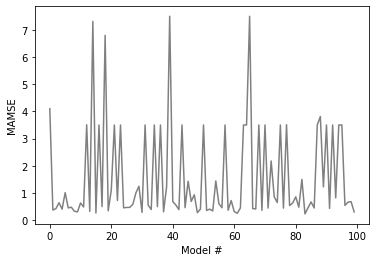

In [6]:
#  Check what the parameters were of the best performing models
fname = f"./cross_validation/ordloss/"
opt_params = pickle.load(open(fname+"opt_par_cv.p", "rb"))
res_table = pickle.load(open(fname+"restable_valid.p", "rb"))

res_table["mamse"].plot(color="grey")
plt.xlabel("Model #")
plt.ylabel("MAMSE")
plt.plot()

print(res_table.sort_values(by=['mamse']).head(10))
print(opt_params)

### Seems to be that multiple model configuarations have comparable performance

## Compare the evolution of validation loss with each epoch

In [8]:
##### This does not need to be executed as the results are saved. #####
opt_par_ep = opt_params.copy()
opt_par_ep["epochs"] = 50
losses, model, theta, oos_losses, _, _ = train(training, "2010-01-01", n_classes, **opt_par_ep, valid = True)

100%|██████████| 2210/2210 [00:04<00:00, 466.26it/s]


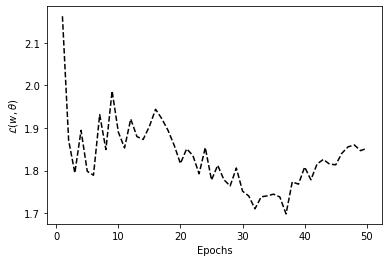

In [9]:
def plot_overfitting(osl, save=False):
    xx = np.arange(1, len(osl)+1)
    plt.plot(xx,osl, c="black", ls="--")
    #plt.axhline(np.min(osl), c="black", lw=0.3)
    plt.xlabel("Epochs")
    plt.ylabel(r"$\mathcal{L}(w, \theta)$")
    if save:
        plt.savefig("./figures/OrdLoss_osl.pdf")
        plt.close()
    else:
        plt.show()
plot_overfitting(oos_losses, save=True)

## Check how the best model in the validation set perform in the test set from 2015-2020 training on 1997-2015

In [10]:
# Full testing
df = pd.read_csv("./data/clean/fulldataset.csv")

# Validation sets.
losses, model, theta, _, X_test, y_test = train(df, "2015-01-01", n_classes, **opt_params, valid = True)

100%|██████████| 2977/2977 [00:07<00:00, 417.06it/s]


In [11]:
y_pred_oos, _ = make_predictions(X_test, model, theta)
bac_oos = metrics.balanced_accuracy_score(y_test, y_pred_oos.numpy())
mamae = macro_averaged_mean_absolute_error(y_test, y_pred_oos.numpy())
mamse = macro_averaged_mean_squared_error(y_test, y_pred_oos.numpy())
wf1 = metrics.f1_score(y_test, y_pred_oos.numpy(), average="weighted")

print(f"\t\tBalanced Accuracy : {bac_oos:.4f}")
print(f"\t\tMacro Averaged MAE : {mamae:.4f}")
print(f"\t\tMacro Averaged MSE : {mamse:.4f}")
print(f"\t\tWeighted F1 : {wf1:.4f}")

		Balanced Accuracy : 0.6563
		Macro Averaged MAE : 0.3686
		Macro Averaged MSE : 0.4183
		Weighted F1 : 0.7708


In [12]:
print(metrics.classification_report(y_test, y_pred_oos.numpy()))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       605
           1       0.75      0.71      0.73       762
           2       0.75      0.80      0.77       618
           3       0.40      0.24      0.30        49

    accuracy                           0.77      2034
   macro avg       0.69      0.66      0.67      2034
weighted avg       0.77      0.77      0.77      2034



## Retrain to get confidence intervals

In [16]:
##### This does not need to be executed as the results are saved. #####
N = 100
scores = []
recalls = []
precisions = []

for _ in tqdm(range(N)):
    losses, model, theta, _, X_test, y_test = train(df, "2015-01-01", n_classes, **opt_params, verbose = False)
    y_pred_oos, _ = make_predictions(X_test, model, theta)
    
    bac_oos = metrics.balanced_accuracy_score(y_test, y_pred_oos.numpy())
    mamae = macro_averaged_mean_absolute_error(y_test, y_pred_oos.numpy())
    mamse = macro_averaged_mean_squared_error(y_test, y_pred_oos.numpy())
    wf1 = metrics.f1_score(y_test, y_pred_oos.numpy(), average="weighted")
    precision = metrics.precision_score(y_test, y_pred_oos.numpy(), average=None)
    recall = metrics.recall_score(y_test, y_pred_oos.numpy(), average=None)

    scores.append({"bac":bac_oos,"mamae":mamae,"mamse":mamse,"wf1":wf1}) 
    recalls.append(recall)
    precisions.append(precision)
        
scores_df = pd.DataFrame(scores)
recalls_df = pd.DataFrame(recalls)
precisions_df = pd.DataFrame(precisions)

pickle.dump(scores_df, open(fname+"scores_df.p", "wb"))
pickle.dump(recalls_df, open(fname+"recalls_df.p", "wb"))
pickle.dump(precisions_df, open(fname+"precisions_df.p", "wb"))

 12%|█▏        | 12/100 [14:05<1:36:25, 65.75s/it]/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 15%|█▌        | 15/100 [17:21<1:32:45, 65.48s/it]/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being se

In [14]:
recalls_df = pickle.load(open(fname+"recalls_df.p", "rb"))
precisions_df = pickle.load(open(fname+"precisions_df.p", "rb"))
scores_df = pickle.load(open(fname+"scores_df.p", "rb"))

#### Confidence intervals

In [15]:
import scipy.stats as st
N = 100
alpha = 0.05
c_crit = st.t.ppf(1-alpha/2, N-1)


results = pd.concat([precisions_df.mean()[:-1], recalls_df.mean()[:-1]], axis=1)
results.columns = ["Precision","Recall"]
results["CI_prec"] = c_crit * precisions_df.std()[:-1]/np.sqrt(N)
results["CI_rec"] = c_crit * recalls_df.std()[:-1]/np.sqrt(N)

avg_mamse = scores_df["mamse"].mean()
ci_mamse = c_crit * scores_df["mamse"].std() / np.sqrt(N)

## Export latex for report

In [16]:
print(results.round(3).to_latex())
print(f"MAMSE :{avg_mamse:.4f} \nCI:+-{ci_mamse:.4f}")

\begin{tabular}{lrrrr}
\toprule
{} &  Precision &  Recall &  CI\_prec &  CI\_rec \\
\midrule
0 &      0.877 &   0.858 &    0.007 &   0.009 \\
1 &      0.756 &   0.711 &    0.004 &   0.005 \\
2 &      0.730 &   0.811 &    0.005 &   0.005 \\
3 &      0.386 &   0.270 &    0.012 &   0.012 \\
\bottomrule
\end{tabular}

MAMSE :0.4059 
CI:+-0.0059
